# Winning

Whether it's Charlie Sheen or an NFL franchise, winning is seen as the single most important objective. But unlike Charlie Sheen, NFL teams need more than tiger blood. In this study, I am going to examine which are the most important offensive factors that give a team the best chance to win a game. Additionally, I want to see if those factors are as important in the playoffs as they are in the regular season. 

## Hypothesis

The recent trend has been to throw on first, second, and third down and rush once in a while to keep the opposing defenses honest. While that works in the regular season, in the playoffs, a team needs a more balanced attack to win.

## Method

I will gather offensive stats from the past 10 NFL seasons. They will be divided into regular season and postseason(playoff) games. Each NFL season has 256 games (16 games/week x 16 weeks/season) for a total of 2560 games in 10 seasons as a pool from which we will randomly sample 1000 games. In the postseason, 12 teams qualify and play a total of 11 games(4-wild card, 4-divisional, 2-conference, and the Super Bowl). That equates to 110 postseason games which would be roughly 10% of the size of the training dataset. I will first compare our model to the regular season games to establish a baseline of accuracy then compare how the same model performs in the playoffs.

## Data

The method which I will be gathering the data will be brute-force which will be a bit labor-intensive. I will be using the website www.pro-football-reference.com to convert the game stats to csv by copying the offense and defense game data on to a spreadsheet and then exporting it as a .csv file.

In [432]:
# Let's load the necessary packages and the data
import numpy as np
import pandas as pd
import pandas_profiling
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time

### Offense Dataset

In [433]:
# import data
col_names = ['win', 'home_game', 'score', 'opp_score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
              'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%', 'qb_rtg',
              'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made', 'fg_att',
              'x_pts_made', 'x_pt_att', 'punts', 'punt_yds', '3_down_conv', '3_down_att', 
              '4_down_conv', '4_down_att', 'time_of_poss']

offense = pd.read_csv('../../../Data/offense.csv', header=None, names=col_names)
#offense.head(5)

Let's fix the 'win' and 'venue' columns.

In [434]:
# first change 'win' column values from string to number type
offense['win'] = np.where(offense['win'] == 'W', 1, 0)

# change venue to more descriptive value 0=away, 1=home
offense['home_game'] = np.where(offense['home_game'] == '@', 0, 1)

# we don't need to know the opponent's score for the offensive model so let's drop that column
offense = offense.drop(['opp_score'], axis=1)

display(offense.head(5))

,win,home_game,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,1,16,26,44,259,1,2,3,29,...,3,1,1,6,328,4,14,0,1,28:23
1,1,0,31,27,32,265,2,0,0,0,...,2,4,4,3,139,2,9,1,1,31:21
2,0,1,21,27,46,226,2,5,2,16,...,0,3,3,4,210,4,10,1,2,27:02
3,1,0,41,22,33,256,5,1,1,5,...,2,5,5,4,166,8,14,0,0,33:16
4,1,1,31,29,38,340,2,0,0,0,...,1,4,4,7,364,2,12,1,2,31:30


That leaves us with the last column in the dataframe that contains the time of possession value as a string. We would need to convert these to numerical values to be able to get meaningful information.

In [435]:
# change 'time_of_poss' values to duration in seconds
# check to see if any values are different than mm:ss
print(offense[offense['time_of_poss'].str.len() < 5])

     win  home_game  score  completions  pass_att  pass_yds  pass_tds  \
19     0          0      7           30        53       201         1   
35     1          1     23           22        40       257         1   
51     0          0     13           19        34       207         1   
67     0          1     20           28        49       399         2   
82     0          0     17           23        40       299         2   
98     0          1      6           20        43       205         1   
287    1          0     21           11        19        90         0   
547    0          0     16           18        32       207         1   

     interceptions  sacks  yds_lost  ...  fg_att  x_pts_made  x_pt_att  punts  \
19               2      6        41  ...       0           1         1      8   
35               1      2        14  ...       3           2         2      7   
51               1      2        18  ...       2           1         1      6   
67               1

In [436]:
# fix incomplete data
offense.at[19, 'time_of_poss'] = '32:40'
offense.at[35, 'time_of_poss'] = '35:00'
offense.at[51, 'time_of_poss'] = '23:50'
offense.at[67, 'time_of_poss'] = '32:00'
offense.at[82, 'time_of_poss'] = '30:30'
offense.at[98, 'time_of_poss'] = '23:20'
offense.at[287, 'time_of_poss'] = '27:00'
offense.at[547, 'time_of_poss'] = '32:20'

In [437]:
# first need to change the format from mm:ss to hh:mm:ss
offense['time_of_poss'] = ['00:' + x for x in offense['time_of_poss']]
# print(offense['time_of_poss'])

In [438]:
# convert strings to seconds 
offense['time_of_poss'] = pd.to_timedelta(offense['time_of_poss'], 'seconds')

In [439]:
# convert to seconds(float)
offense['time_of_poss'] = offense['time_of_poss'].dt.total_seconds()

In [277]:
# print(offense['time_of_poss'])

In [440]:
# Let's gather some stats on the stats
pandas_profiling.ProfileReport(offense)

Number of variables,28
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,218.8 KiB
Average record size in memory,224.1 B
Numeric,23
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,3


In [442]:
# post season offense data
post_off = pd.read_csv('../../../Data/postoffense.csv', header=None, names=col_names)
post_off.head(5)

,win,home_game,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,L,NaN,14,24,18,36,110,1,1,3,...,2,2,2,4,192,5,14,0,1,26:58
1,W,NaN,34,14,23,35,228,2,0,2,...,2,4,4,6,229,9,16,0,0,39:34
2,W,@,33,14,4,10,34,0,1,0,...,2,3,3,4,136,10,16,0,0,32:21
3,W,NaN,51,45,29,33,375,5,0,1,...,2,6,6,1,26,3,5,0,0,31:27
4,W,NaN,45,14,23,32,247,3,0,0,...,1,6,6,4,171,7,13,0,1,36:27


In [443]:
print(post_off[post_off['time_of_poss'].str.len() < 5])

Empty DataFrame
Columns: [win, home_game, score, opp_score, completions, pass_att, pass_yds, pass_tds, interceptions, sacks, yds_lost, yds_per_pass_att, comp_%, qb_rtg, rush_att, rush_yds, yds_per_rush_att, rush_tds, fgs_made, fg_att, x_pts_made, x_pt_att, punts, punt_yds, 3_down_conv, 3_down_att, 4_down_conv, 4_down_att, time_of_poss]
Index: []

[0 rows x 29 columns]


I guess I did a better job of data entry on the playoff dataset. Whew!

In [444]:
# first change 'win' column values from string to number type
post_off['win'] = np.where(post_off['win'] == 'W', 1, 0)

# change venue to more descriptive value 0=away, 1=home
post_off['home_game'] = np.where(post_off['home_game'] == '@', 0, 1)

# we don't need to know the opponent's score for the offensive model so let's drop that column
post_off = post_off.drop(['opp_score'], axis=1)

# first need to change the format from mm:ss to hh:mm:ss
post_off['time_of_poss'] = ['00:' + x for x in post_off['time_of_poss']]

# convert strings to seconds 
post_off['time_of_poss'] = pd.to_timedelta(post_off['time_of_poss'], 'seconds')

# convert to seconds(float)
post_off['time_of_poss'] = post_off['time_of_poss'].dt.total_seconds()

post_off.head(5)

,win,home_game,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,1,14,18,36,110,1,1,3,36,...,2,2,2,4,192,5,14,0,1,1618.0
1,1,1,34,23,35,228,2,0,2,16,...,2,4,4,6,229,9,16,0,0,2374.0
2,1,0,33,4,10,34,0,1,0,0,...,2,3,3,4,136,10,16,0,0,1941.0
3,1,1,51,29,33,375,5,0,1,4,...,2,6,6,1,26,3,5,0,0,1887.0
4,1,1,45,23,32,247,3,0,0,0,...,1,6,6,4,171,7,13,0,1,2187.0


## Visualizations

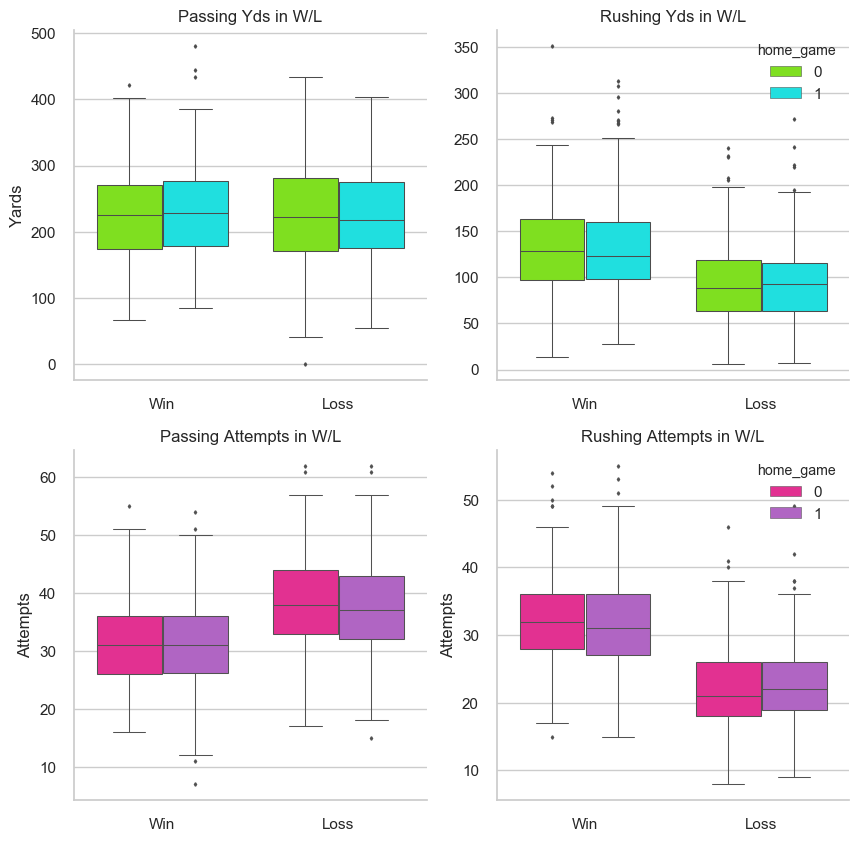

In [490]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.set(style='whitegrid')
sns.despine()

x = 'win'
hue = 'home_game'

ax1 = axes[0, 0]
sns.boxplot(x=x, y='pass_yds', hue=hue, data=offense, order=[1, 0], ax=ax1, palette=['chartreuse', 'aqua'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax1.set_title('Passing Yds in W/L')
ax1.set_ylabel('Yards')
ax1.set_xlabel('')
ax1.get_legend().remove()
ax1.set_xticklabels(['Win', 'Loss'])

ax2 = axes[0, 1]
sns.boxplot(x=x, y='rush_yds', hue=hue, data=offense, order=[1, 0], ax=ax2, palette=['chartreuse', 'aqua'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax2.set_title('Rushing Yds in W/L')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticklabels(['Win', 'Loss'])

ax3 = axes[1, 0]
sns.boxplot(x=x, y='pass_att', hue=hue, data=offense, order=[1, 0], ax=ax3, palette=['deeppink', 'mediumorchid'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax3.set_title('Passing Attempts in W/L')
ax3.set_ylabel('Attempts')
ax3.set_xlabel('')
ax3.get_legend().remove()
ax3.set_xticklabels(['Win', 'Loss'])

ax4 = axes[1, 1]
sns.boxplot(x=x, y='rush_att', hue=hue, data=offense, order=[1, 0], ax=ax4, palette=['deeppink', 'mediumorchid'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax4.set_title('Rushing Attempts in W/L')
ax4.set_ylabel('Attempts')
ax4.set_xlabel('')
ax4.set_xticklabels(['Win', 'Loss'])

plt.show()

That is certainly interesting. Passing yards doesn't show much difference between wins and losses, but there definitely is a trend of winning teams gaining more rush yards than losing teams. There is also a very peculiar outlier for passing yards in an away team loss. 0 passing yards? That seems hard to believe in today's pass-happy offenses. So let's see if this is erroneous or an actual game record.

In [116]:
# find the record that has 0 passing yards
no_pass_yds = offense[offense['pass_yds'] == 0]
display(no_pass_yds)

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
862,0,away,0,37,4,19,0,0,1,3,...,0,0,0,7,275,1,11,1,1,18:46


Ahh. So it looks like this definitely wasn't an erroneous record. This team completed only 4 passes in 19 passing attempts in a shutout loss. Definitely won't win too many games with this kind of offense. I have a strong suspicion that this was a 16-loss team (read: Browns or Raiders) game that went horribly wrong. Or maybe, just maybe, it could be a relic of dark times in my Broncos' history that was Tim Tebow-led offense that still gives me the shudders to this day everytime I think about it.

Since we are dealing with sports statistic, it is inevitable that certain varaibles will be closely correlated. The score will obviously be correlated to touchdowns scored, pass yards will be correlated to pass completions and so on. I want to plot each to quantify to relationships and see if we can eliminate some that are highly redundant.

### Correlation Matrix

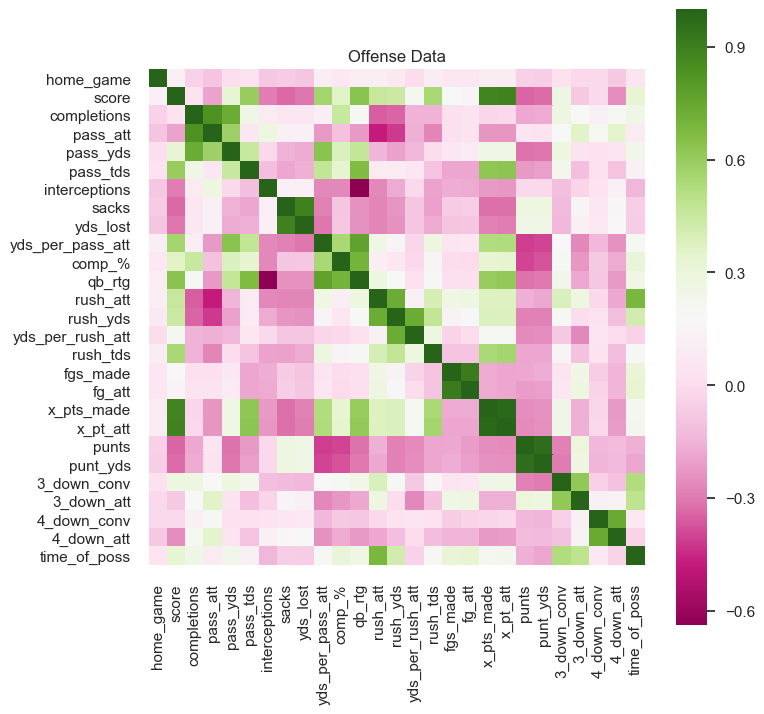

In [300]:
# Let's pull the relevant data from the table and store it
off_features = offense.drop(['win'], axis=1)

# Let's plot a matrix
corrmat = off_features.corr()

plt.subplots(figsize=(8, 8))
sns.set(style='white')
sns.despine()

sns.heatmap(data=corrmat, cmap="PiYG", square=True)

plt.title('Offense Data')
plt.show()

I think this correlation matrix doesn't look too bad. Relatively speaking the only one I may have take a closer look at is the relationship between qb_rtg and interceptions. x_pts_made and x_pt_att is most definitely redundant since it was almost a given that kickers made the extra point attempts and sports do not play well with "a sure thing." This is mainly the reason that the league moved the extra point attempts from the 3-yard line to the 15-yard line. 

In [406]:
# remove x_pt_att
off_features = off_features.drop(['x_pt_att'], axis=1)

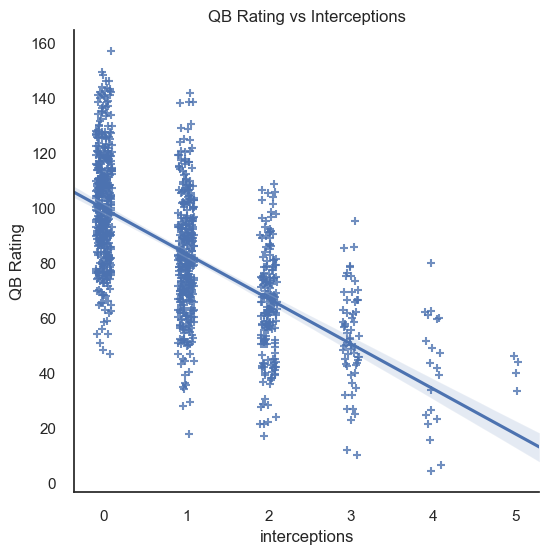

In [289]:
# Plot qb_rtg vs interceptions
f, ax = plt.subplots(figsize=(6, 6))
sns.set(style='ticks')
sns.despine()

sns.regplot(x='interceptions', y='qb_rtg', data=offense, x_jitter=0.1, marker='+')

plt.title('QB Rating vs Interceptions')
plt.ylabel('QB Rating')
plt.show()

That's a pretty strong correlation. Each interception results in about 20 point drop in QB rating. Since the way QB rating is calculated is unclear other than the fact that it incorporates all the things a QB does such as pass yards and touchdowns, let's drop QB rating from our features set.

In [407]:
# drop qb_rtg from features
off_features = off_features.drop('qb_rtg', axis=1)
off_features.columns

Index(['home_game', 'score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
       'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%',
       'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made',
       'fg_att', 'x_pts_made', 'punts', 'punt_yds', '3_down_conv',
       '3_down_att', '4_down_conv', '4_down_att', 'time_of_poss'],
      dtype='object')

Let's move forward now with these features and build a model that can predict the wins.

## Models

Now to the fun part! Our target variable is either a win or a loss. So I will employ different classification models to see which performs the best. 

In [409]:
# designate dependent and independent variables
X_train = off_features
y_train = offense['win']

X_test = post_off.drop(['win', 'qb_rtg', 'x_pt_att'], axis=1)
y_test = post_off['win']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1000, 25) (110, 25) (1000,) (110,)


In [327]:
# Naive-Bayes classifier
# start timer
start_time = time.time()

bn = BernoulliNB()
bn_model = bn.fit(X_train, y_train)
cvs = cross_val_score(bn_model, X_train, y_train, cv=10)

elapsed = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

Elapsed time: 0.043 seconds
Cross Value Scores:
 [0.78217822 0.78       0.79       0.77       0.71       0.74
 0.76       0.74       0.68       0.73737374]
Mean Score: 0.7490


In [410]:
# ridge regresssion
start_time = time.time()

lr = linear_model.LogisticRegression(C=1/15, solver='lbfgs', max_iter=4500)
lr_model = lr.fit(X_train, y_train)
cvs = cross_val_score(lr_model, X_train, y_train, cv=10)

elapsed = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

y_pred = lr_model.predict(X_test)
c_mat = confusion_matrix(y_test, y_pred)

print('R2 Score: ', lr_model.score(X_test, y_test))
print('Confusion Matrix:\n', c_mat)

Elapsed time: 3.175 seconds
Cross Value Scores:
 [0.86138614 0.84       0.84       0.84       0.89       0.93
 0.87       0.87       0.87       0.82828283]
Mean Score: 0.8640
R2 Score:  0.8727272727272727
Confusion Matrix:
 [[42  5]
 [ 9 54]]


In [328]:
# KNN Classifier
start_time = time.time()

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model = knn.fit(X_train, y_train)
cvs = cross_val_score(knn_model, X_train, y_train, cv=10)

elapsed = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

Elapsed time: 0.067 seconds
Cross Value Scores:
 [0.72277228 0.74       0.81       0.69       0.75       0.75
 0.79       0.7        0.75       0.70707071]
Mean Score: 0.7410


In [329]:
# SVM classifier
start_time = time.time()

svc = svm.SVC(kernel='linear')
svc_model = svc.fit(X_train, y_train)
cvs = cross_val_score(svc_model, X_train, y_train, cv=10)

elpased = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

Elapsed time: 0.067 seconds
Cross Value Scores:
 [0.88118812 0.83       0.84       0.84       0.89       0.9
 0.86       0.86       0.86       0.80808081]
Mean Score: 0.8569


In [341]:
# Random forest model
start_time = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=65, max_depth=6)
rfc_model = rfc.fit(X_train, y_train)
cvs = cross_val_score(rfc_model, X_train, y_train, cv=10)

elapsed = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

Elapsed time: 1.244 seconds
Cross Value Scores:
 [0.84158416 0.85       0.82       0.82       0.86       0.91
 0.87       0.89       0.88       0.86868687]
Mean Score: 0.8610


In [357]:
# gradient boost model
start_time = time.time()

clf = ensemble.GradientBoostingClassifier(n_estimators=65, max_depth=6, subsample=0.85)
clf_model = clf.fit(X_train, y_train)
cvs = cross_val_score(clf_model, X_train, y_train, cv=10)

elapsed = time.time() - start_time

print('Elapsed time: %0.3f seconds' % elapsed)
print('Cross Value Scores:\n', cvs)
print('Mean Score: %0.4f' % np.mean(cvs))

Elapsed time: 3.177 seconds
Cross Value Scores:
 [0.85148515 0.83       0.86       0.81       0.85       0.88
 0.84       0.88       0.84       0.85858586]
Mean Score: 0.8500
